In [1]:
from SliceNet import SliceNet
from netUtils import getSingleExample
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math

import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
TF_CPP_MIN_LOG_LEVEL=2

%load_ext autoreload
%autoreload 2

W0423 02:25:27.302884 140197271750400 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1


Using TensorFlow backend.


importing hub
Instructions for updating:
Colocations handled automatically by placer.


W0423 02:25:28.643944 140197271750400 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [2]:
net = SliceNet(classification=True)
weights_path = '/home/bmmidei/SliceCast/models/04_20_2019_2300_final.h5'

## Sample predictions on unseen wiki articles

In [3]:
dataPath = Path('/home/bmmidei/SliceCast/data/dev/hdf5')
files = [str(x) for x in dataPath.glob('**/*') if x.suffix=='.hdf5']

mask = random.sample(range(0,len(files)), 1)

# randomly select a file to test
test_file = [x for (i,x) in enumerate(files) if i in mask][0]

In [11]:
preds, labels = net.predict(test_file=test_file,
                    num_samples=8,
                    weights_path=weights_path)

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8173b654e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [12]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

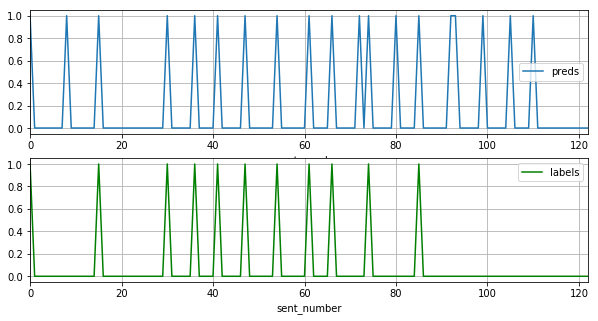

In [18]:
# Choose the document you want to examine
idx = 5

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Sample predictions on unseen podcast data

In [19]:
test_file = '/home/bmmidei/SliceCast/data/podcasts/hdf5/batch0_0.hdf5'
weights_path = '/home/bmmidei/SliceCast/models/04_22_2019_2300_podcast.h5'

preds, labels = net.predict(test_file=test_file,
                    num_samples=4,
                    weights_path=weights_path)

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f822d0fb9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [20]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)




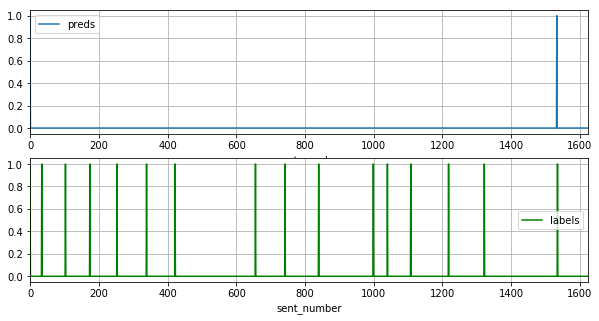

In [28]:
# Choose the document you want to examine
idx = 3

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Predictions on a single text file

In [47]:
text_file = '/home/bmmidei/SliceCast/data/test/02/02/04/202048'
is_labeled = True
weights_path = '/home/bmmidei/SliceCast/models/04_20_2019_2300_final.h5'

sents, labels = getSingleExample(fname=text_file, is_labeled=is_labeled)
sents = np.expand_dims(sents, axis=0)
print(sents.shape)
print(len(labels))
preds = net.singlePredict(sents, weights_path=weights_path)
print(preds.shape)

(1, 142)
142
Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f81400a13c8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


(1, 142, 3)


(142,)


In [52]:
# Place data into a pandas dataframe for analysis
df = pd.DataFrame()

preds = np.argmax(np.squeeze(preds), axis=-1)
df['raw_sentences'] = sents[0]
if is_labeled:
    df['labels'] = labels
df['preds'] = preds


In [53]:
df.head(50)

,raw_sentences,labels,preds
0,Iraq Body Count project (IBC) is a web-based e...,1,1
1,Included are deaths attributable to coalition ...,0,0
2,"As of December 2012, the IBC has recorded 110,...",0,0
3,The IBC has a media-centered approach to count...,0,0
4,Other sources have provided differing estimate...,0,0
5,See Casualties of the Iraq War.,0,0
6,The project uses reports from English-language...,0,1
7,"On its database page the IBC states: ""Gaps in ...",0,0
8,The group is staffed by volunteers consisting ...,0,0
9,The project was founded by John Sloboda and Ha...,0,0


In [43]:
print(preds)


0
